In [3]:
import numpy as np
import tensorflow as tf
import pylab
%matplotlib inline

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from random import shuffle # For shuffling start position list

Dim. of X-data: 484 x 2
Mean p: 
[ 0.55165289  0.46900826  0.4607438   0.53305785  0.54338843  0.57644628
  0.47520661  0.49793388  0.41942149  0.60123967  0.49793388  0.52066116
  0.48966942  0.50413223  0.58884298  0.43801653  0.49380165  0.48760331
  0.53099174  0.50826446  0.42768595  0.46487603  0.49793388  0.45247934
  0.54752066  0.46280992  0.43595041  0.39256198  0.4607438   0.59504132
  0.41115702  0.50619835  0.5         0.50206612  0.46900826  0.46900826
  0.48966942  0.56198347  0.4731405   0.46694215  0.51239669  0.4607438
  0.48140496  0.5268595   0.53719008  0.57644628  0.5268595   0.53512397
  0.51033058  0.46694215  0.44834711  0.4731405   0.32438017  0.61157025
  0.54958678  0.57644628  0.61363636  0.44214876  0.53305785  0.52066116
  0.53512397  0.44214876  0.51859504  0.46694215  0.60330579  0.48140496
  0.46280992  0.40495868  0.45867769  0.57438017  0.46694215  0.61983471
  0.49586777  0.55371901  0.51859504  0.5         0.36570248  0.50619835
  0.50413223  0.454

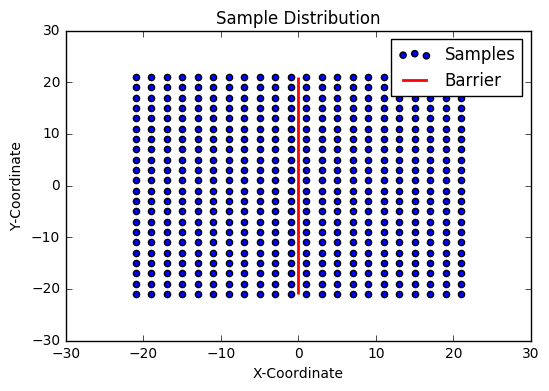

In [4]:
nr_inds=500  # Nr. of Individuals to Check

X_data = np.loadtxt('./coordinates10.csv', delimiter='$').astype('float64') # Load the complete X-Data
Y_data = np.loadtxt('./data_genotypes10.csv', delimiter='$').astype('float64') # Load the complete Y-Data
#print(len(X_data))
inds=range(len(X_data))
shuffle(inds)  # Random permutation of the indices. If not random draw - comment out
inds=inds[:nr_inds]  # Only load first nr_inds


# Only load first nr_inds entries
X_data = X_data[inds,:]
#X_data = np.array([[1,1],[1,0],[-1,1],[-1,0]])   # For debugging
Y_data = Y_data[inds,:]
#Y_data = np.array([[0, 1], [0, 0],[1, 1], [0, 0]])



#./data_genotypes5.csv has mean p=0.2
assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
nr_loci = Y_data.shape[1]


p_mean = np.mean(Y_data, axis=0) # Empirical average for every loci
#p_mean=np.mean(Y_data)
print("Mean p: ")
print(p_mean)

# Change this for coordinates5.csv  (If mean is known)
#f_mean = np.loadtxt('./mean_f6.csv', delimiter='$').astype('float64')[inds]   # Empirical f_mean
#f_mean = np.log(p_mean) - np.log(1 - p_mean) # Does a Logit Transform
#f_mean=np.log(0.2)-np.log(1.0-0.2)   # If known

#print(len(f_mean))
#print(len(f_mean))
Y_data[Y_data < 0.5] = -1.0  # For the logit Link function
print("Dim. of Y-data: %i x %i" % (M1, nr_loci))

#mean_paramss = np.array([f_mean for _ in range(nr_loci)]) # Initial Parameter for the mean-parameters
#mean_paramss = np.array([0.0 for _ in range(nr_loci)])  # Set everything to 0
mean_paramss = np.array([np.pi/2.0 for _ in range(nr_loci)])  # Set everything to 0.5. For ArcSin Model
#mean_paramss = np.array(f_mean)
print("Assumed f-mean:")
print(mean_paramss[:10])

# Plot the data
pylab.figure()
pylab.title("Sample Distribution")
pylab.scatter(X_data[:,0], X_data[:,1], label = "Samples")
pylab.vlines(0, min(X_data[:,1]), max(X_data[:,1]),linewidth=2, color="red", label="Barrier")
pylab.xlabel("X-Coordinate")
pylab.ylabel("Y-Coordinate")
pylab.legend()
pylab.show()

In [5]:
###### The Full Kernel:
def full_kernel_function(coords, l, a, c):
    '''Return barrier Kernel - describing reduced correlation across barrier
    and increased correlation next to barrier. Coords is nx2 Numpy array.
    Barrier is assumed to be at x=0'''
    x = coords[:, 0]  # Extracts x-coords
    
    mask = tf.constant([-1.0, 1.0], dtype=tf.float64) # Mask used for reflecting coordinates
    
    coords_refl = coords * mask[None,:]  # Reflects the x-Coordinate
    
    g = tf.sign(x)  # Calculates Signum of x
    same_side = (g[:,None] * g + 1) / 2  # Whether the x-Values are on the same side
    #print("Same Side Vector: ")
    #print(same_side)
    
    r_sqrd = tf.reduce_sum(((coords[:, None] - coords[None, :]) ** 2), reduction_indices=[2])  # Calculates pairwise Distance
    r_refl_sqrd = tf.reduce_sum(((coords_refl[:, None] - coords[None, :]) ** 2), reduction_indices=[2])  # Calculates the reflected Distance 
    
    # Calculate the normal Kernel:
    cov_mat = a * tf.exp(-r_sqrd / (2. * l ** 2))  # Calculate the co-variance matrix. Added diagonal term
    cov_mat_refl = a * tf.exp(-r_refl_sqrd / (2. * l ** 2))  # Calculate the covariance matrix for reflected coordinates.
    K = same_side * (cov_mat + c * cov_mat_refl) + (1 - same_side) * (1 - c) * cov_mat
    
    #print("Covariance Matrix: ")
    #print(cov_tot)
    #print("Eigenvalues: ")
    #print(np.linalg.eig(cov_mat)[0])
    return K

def rbf_kernel_function(coords, l, a):
    '''The usual exponential kernel function'''
    K = a * tf.exp(-tf.reduce_sum(((coords[:, None] - coords[None, :]) ** 2) / (2 * l**2), reduction_indices=[2]))
    return K

In [6]:
# From Alex: To calculate the log determinant

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def py_logdet(x, name=None):
    
    with ops.op_scope([x], name, "Logdet") as name:
        logdet = py_func(lambda x: np.linalg.slogdet(x)[1],
                         [x],
                         [tf.float64],
                         name=name,
                         grad=_LogdetGrad)  # <-- here's the call to the gradient
    return logdet[0]

def _LogdetGrad(op, grad):
    x = op.inputs[0]
    return tf.matrix_inverse(x) * grad[:, None, None]

In [22]:
# For logit Link function

with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.5, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    #hyper_params = tf.placeholder(shape=[3 + nr_loci], dtype=tf.float64)      # HyperParameters for the Kernel
    hyper_params = tf.placeholder(shape=[3], dtype=tf.float64)
    hyper_params_means=tf.placeholder(shape=[nr_loci], dtype=tf.float64)
    # First two are for the kernel; nr_loci are for the means of the GRFs!
    #mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    a = tf.abs(hyper_params[0])     # The Parameter for the absolute Correlation
    l = tf.abs(hyper_params[1])     # The Parameter for the Length Scale
    c = tf.abs(hyper_params[2])     # The Parameter for the "Reflection Factor"
    mean_param = hyper_params[3:]   # The Parameter for the Mean
    
    eye = tf.eye(N)

    # The Kernel for the classical Covariance Matrix
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l **2), reduction_indices=[2])) + \
    #    0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    # The Kernel for the full covariance Matrix:
    K = full_kernel_function(X, l, a, c)
    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
       0.0001 * eye                

    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = tf.nn.sigmoid(f_tot)            # Calculate probabilities(assuming sigmoid link function)
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    data_fit = -tf.reduce_sum(tf.log(1 + tf.exp(-Y * f_tot)), reduction_indices=[0]) # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calculate 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    g =  (0.5 * (Y + 1) - p) - Kinv_F # Calculate Matrix for Gradients Check
    
    W = p * (1 - p)        # Calculate first part of Hessian. It is diagonal (but here diagonal in every column)
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEADACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    ##### Gradients and Hessian #######################3
    
    #grad = tf.gradients(margL, hyper_params)
    #hessian = tf.hessians(margL, hyper_params)  # Comment out to avoid computational overhead.

ValueError: Tensor conversion requested dtype float64 for Tensor with dtype float32: 'Tensor("mul_81:0", shape=(200, 200), dtype=float32, device=/device:CPU:0)'

In [7]:
# For sin^2(x/2) Link function
def link_f(f):   # Define Link function
    '''Sinus Squared Link function'''
    pi=0.999*np.pi*tf.ones((N, nr_loci), dtype=tf.float64)  # Matrix - for values bigger than Pi. 
    #Allow for values slightly smaller than Pi to infinte likelihood (to avoid infinities)
    z=0.001*tf.ones((N, nr_loci), dtype=tf.float64)       
    # Matrix - for values smaller than 0. Allow for small values slightly bigger than 1 (to avoid infinities)
    f=tf.where(f>np.pi, pi, f)       # Make values bigger than pi almost pi
    f=tf.where(f<0, z, f)            # Make values smaller than 0 almost 0
    
    y = tf.sin(0.5*f) ** 2        # Do the actual calculation
    return y

with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.0, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    #hyper_params = tf.placeholder(shape = [3 + nr_loci], dtype=tf.float64)      # HyperParameters for the Kernel
    hyper_params = tf.placeholder(shape=[3], dtype=tf.float64)                # The Kernel Hyper Parameters
    hyper_params_means =tf.placeholder(shape=[nr_loci], dtype=tf.float64)      # The Mean Hyper Parameters
    # First two are for the kernel; nr_loci are for the means of the GRFs!
    #mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    a = tf.abs(hyper_params[0])     # The Parameter for the absolute correlation
    l = tf.abs(hyper_params[1])     # The Parameter for the length scale
    c = tf.abs(hyper_params[2])
    #mean_param = hyper_params[3:]   # The mean parameters
    mean_param = hyper_params_means
    
    eye = tf.eye(N, dtype=tf.float64)

    # The Kernel for the classical Covariance Matrix
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l**2), reduction_indices=[2])) + 0.00001*eye\
    #0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    # The Kernel for the full covariance Matrix:
    #K = rbf_kernel_function(X, l, a) + 0.00001 *eye
    K = full_kernel_function(X, l, a, c) + 0.00001 * eye # Add identity to make positive definite
 
    
    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = link_f(f_tot)    # Calculate novel p, assuming sin^2 Link Function
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    g0 = tf.greater(Y, 0.5)        # Values where Y is greater than 0; i.e. data is 1.
    g0 = tf.cast(g0, tf.float64)   # Transform so that can be multiplied

    y_f= g0*p + (1-g0)*(1-p)  # Probability of observing y given probabilities p
    
    data_fit = tf.reduce_sum(tf.log(y_f), reduction_indices=[0])   # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calculate 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    d1 = 1.0/tf.tan(0.5*f_tot)   # Gradient coming from f_tot (for y=1)
    d0 = -tf.tan(0.5*f_tot)      # Gradient comfing from t_tot (for y=0)
    
    grad1 = g0*d1 + (1-g0)*d0  # First part of the gradient
    
    g =  grad1 - Kinv_F       # Calculate Matrix for Gradients Check
    
    h1 = -0.5 / ((tf.sin(0.5 * f_tot))**2) # Minus second derivative of data. (for y=1)
    h0 = -1.0 / (1 + tf.cos(f_tot))        # Second derivative of data (for y=0)
    W = - g0*h1 - (1-g0)*h0       # Calculate first part of Hessian. It is diagonal (but here diagonal in every column)
    
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEAD-ACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    ##### Gradients and Hessian #######################3
    
    grad = tf.gradients(margL, hyper_params)
    hessian = tf.hessians(margL, hyper_params)  # Comment out to avoid computational overhead.

In [8]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.01

In [9]:
### Optimization Run
hyper_paramss = np.array([0.02, 25, 0.2]) # The initial values for a & L & c
mps = mean_paramss

#kk =  np.array([0.012, 20] + f)



with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(100):
        print("Doing Run: %i" %i)
        _, r,  g, h = sess.run([opt_op, margL, grad, hessian], {hyper_params: hyper_paramss, hyper_params_means: mps})  
        print(r)
        
        if i < 3:  # First three times just run to optimize f_i
            continue
        
        u = np.matmul(np.linalg.inv(h[0]), g[0]) 
        hyper_paramss -= u
        print(hyper_paramss, u)
    
    # Code for calculating empirical Fisher-Information Matrix:
fisher_info = np.matrix(h[0])
stds = np.sqrt(np.diag(-fisher_info.I)) # Calculates the Standard Deviations (Sqrt of Variance)
print("Standard Deviations: ")
print(stds)

Doing Run: 0
-22635767.8884
Doing Run: 1
-33226.339051
Doing Run: 2
-33225.8623254
Doing Run: 3
-33225.8622885
(array([  2.07203845e-02,   2.48710426e+01,   2.39381243e-01]), array([-0.00072038,  0.12895735, -0.03938124]))
Doing Run: 4
-33222.520468
(array([  2.07872231e-02,   2.47658933e+01,   2.73143471e-01]), array([ -6.68386229e-05,   1.05149392e-01,  -3.37622279e-02]))
Doing Run: 5
-33218.4342787
(array([  2.09130329e-02,   2.46512789e+01,   3.11240956e-01]), array([-0.00012581,  0.11461439, -0.03809749]))
Doing Run: 6
-33215.5577446
(array([  2.08516386e-02,   2.45447608e+01,   3.49692028e-01]), array([  6.13943142e-05,   1.06518041e-01,  -3.84510717e-02]))
Doing Run: 7
-33213.0826652
(array([  2.07591765e-02,   2.44400849e+01,   3.88132522e-01]), array([  9.24621429e-05,   1.04675898e-01,  -3.84404947e-02]))
Doing Run: 8
-33211.1282476
(array([  2.06111153e-02,   2.43424541e+01,   4.25420918e-01]), array([ 0.00014806,  0.09763079, -0.0372884 ]))
Doing Run: 9
-33209.5754805
(arra

In [14]:
for i in range(len(hyper_paramss)):
    print("Hyperparameter %i: " %i)
    print("MLE Estimate: %.6f" % hyper_paramss[i])
    print("Standard Deviation: %.6f" % stds[i])

Hyperparameter 0: 
MLE Estimate: 0.017700
Standard Deviation: 0.001217
Hyperparameter 1: 
MLE Estimate: 23.031672
Standard Deviation: 0.559086
Hyperparameter 2: 
MLE Estimate: 0.844532
Standard Deviation: 0.042734


In [15]:
#a_list = np.logspace(-1.5, -0.5, 10)   # Original Values

a_list=np.logspace(-3,-1.5,10)
l_list = np.logspace(0.5, 2, 10)
#c_list = np.logspace(-0.4, 0, 10)
c_list =np.linspace(0,1,10)

#a_list = np.logspace(-3, -0.5, 10)
#l_list = np.logspace(0, 2, 10)


print(a_list)
print(l_list)
print(c_list)

[ 0.001       0.0014678   0.00215443  0.00316228  0.00464159  0.00681292
  0.01        0.01467799  0.02154435  0.03162278]
[   3.16227766    4.64158883    6.81292069   10.           14.67799268
   21.5443469    31.6227766    46.41588834   68.12920691  100.        ]
[ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
  0.66666667  0.77777778  0.88888889  1.        ]


In [ ]:
res = []
j=0
print("Mean Parameters: ")
print(mean_paramss[:10])
with tf.Session(config=config) as sess:
    aa = 0.02  # The true Value
    #cc = 0.0 # The value for the barrier
    #for aa in a_list:
    for cc in c_list:  # Replaced aa with cc
        for ll in l_list:
            print("Doing run: %i" % j)
            j+=1
    
            sess.run(tf.global_variables_initializer())   # Changed to global_variables_initializer

            prev = None
            for i in range(20):
                #hyper_paramss = np.array([aa,ll])
                #hyper_paramss = np.append(hyper_paramss, mean_paramss)
                
                hyper_paramss = np.array([aa, ll, cc])
                #hyper_paramss = np.append(hyper_paramss, mean_paramss)
                
                r = sess.run([opt_op, update, logL, margL], {hyper_params: hyper_paramss, hyper_params_means: mean_paramss})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            print("Tested a: %4f" % aa)
            print("Tested l: %4f" % ll)
            print("Tested c: %4f" % cc)
            print("Marginal Likelihood: %4f" % r[-1])
            res.append(r[-1])

Mean Parameters: 
[ 1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633]
Doing run: 0
Tested a: 0.020000
Tested l: 3.162278
Tested c: 0.000000
Marginal Likelihood: -33452.407269
Doing run: 1
Tested a: 0.020000
Tested l: 4.641589
Tested c: 0.000000
Marginal Likelihood: -33389.421461
Doing run: 2
Tested a: 0.020000
Tested l: 6.812921
Tested c: 0.000000
Marginal Likelihood: -33323.953841
Doing run: 3
Tested a: 0.020000
Tested l: 10.000000
Tested c: 0.000000
Marginal Likelihood: -33277.179280
Doing run: 4
Tested a: 0.020000
Tested l: 14.677993
Tested c: 0.000000
Marginal Likelihood: -33259.728143
Doing run: 5
Tested a: 0.020000
Tested l: 21.544347
Tested c: 0.000000
Marginal Likelihood: -33266.392252
Doing run: 6
Tested a: 0.020000
Tested l: 31.622777
Tested c: 0.000000
Marginal Likelihood: -33287.956979
Doing run: 7
Tested a: 0.020000
Tested l: 46.415888
Tested c: 0.000000
Marginal Likelihood: -33315.088215
Doing run: 8
T

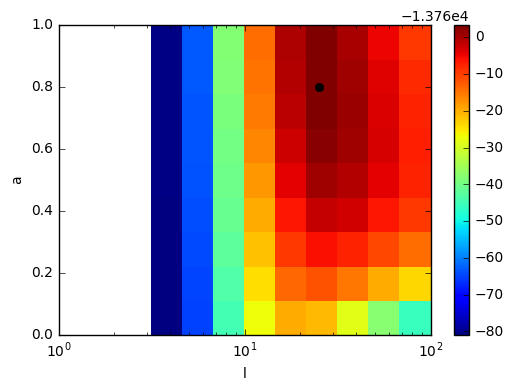

In [11]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(l_list, c_list, surface)
#pylab.pcolormesh(, a_list, surface)
pylab.xscale('log')
#pylab.yscale('log')
pylab.xlabel('l')
pylab.ylabel('a')
pylab.colorbar()
#pylab.plot(25, 0.1, 'ko', linewidth=5)
pylab.plot(25, 0.8, 'ko', linewidth=5)

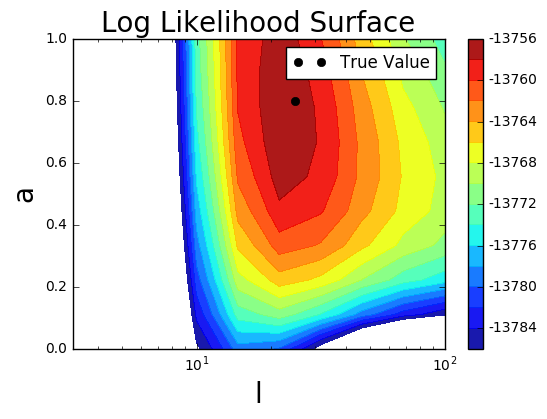

In [12]:
pylab.figure()
levels = np.arange(max(res) - 30, max(res) + 1, 2)  # Every two likelihood units
#ax=pylab.contourf(l_list, a_list, surface, alpha=0.9, levels=levels)
ax=pylab.contourf(l_list, c_list, surface, alpha=0.9,levels=levels)

# plt.clabel(ax, inline=1, fontsize=10)
pylab.colorbar(ax, format="%i")
pylab.title("Log Likelihood Surface", fontsize=20)
pylab.xlabel("l", fontsize=20)
pylab.ylabel("a", fontsize=20)
pylab.xscale('log')
#pylab.yscale('log')
pylab.plot(25, 0.8, 'ko', linewidth=5, label="True Value")
pylab.legend()
pylab.show()

In [11]:
aa, ll = 1, 1
kk = np.array([1, 1, 0.8])   #a,l,c
kk = np.append(kk, mean_paramss)
print("Hyper Parameters: ")
print(kk[:10])

Hyper Parameters: 
[ 1.          1.          0.8         1.57079633  1.57079633]


In [12]:
# Single Run; where optimization is computed.
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())   # Update by Harald
    
    for i in range(5):
        sess.run(opt_op, {hyper_params: kk})
    r = sess.run([f_tot, F, logdet, margL, K], {hyper_params: kk})
print("f_tot:")
print(r[0])
print("F:")
print(r[1])
print("logdet:")
print(r[2])
print("Marg.L")
print(r[3])
print("K")
print(r[4])

f_tot:
[[ 0.81504746  1.89272155]
 [ 0.80277107  1.24887111]
 [ 1.87904308  1.89272155]
 [ 1.24676336  1.24887111]]
F:
[[-0.75574887  0.32192522]
 [-0.76802525 -0.32192522]
 [ 0.30824676  0.32192522]
 [-0.32403296 -0.32192522]]
logdet:
4.37692350631
Marg.L
-6.06215502175
K
[[ 1.10827823  0.67219866  0.02706706  0.016417  ]
 [ 0.67219866  1.10827823  0.016417    0.02706706]
 [ 0.02706706  0.016417    1.10827823  0.67219866]
 [ 0.016417    0.02706706  0.67219866  1.10827823]]


In [136]:
x, y, z = X_data[:nr_inds, 0], X_data[:nr_inds, 1], r[0][:,1]
#x=np.linspace(0, 1, 20)
#print(len(x))
print(len(x))
print(len(y))
print(len(z))

100
100
100


In [100]:
pylab.pcolormesh(x, y, z.reshape(21,21))
pylab.colorbar()

ValueError: total size of new array must be unchanged

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
z.shape

In [ ]:
961 ** 0.5

In [92]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = 0, trainable=False)

In [3]:
with tf.device('/cpu:0'):   # For debugging
    c = 3*tf.ones((5,2), dtype=tf.float64)
    d = tf.constant([-1,1], dtype=tf.float64)
    e= c * d[None,:]
    f = c[:,0]

In [4]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r=sess.run([c,d,e,f])

In [5]:
r[-1]

array([ 3.,  3.,  3.,  3.,  3.])

In [ ]:
tf.__version__

In [ ]:
logdet

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run(logdet, {a: 1.0, l: 1.0})

In [ ]:
r